In [67]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
import pickle

ARMA Models
- We utilize the one-year daily stock price of MRNA (Moderna stock), and process the ARMA model


In [68]:
data = pd.read_csv('/Users/wangmeiyi/Desktop/100dataset/MRNA.csv', index_col = 0)

# rescale the data to log difference form
def Log_diff(x):
    x_diff = 100* np.log(x/x.shift(1))
    x_diff = x_diff.dropna()
    return x_diff

data = Log_diff(data)
print(data.head)


<bound method NDFrame.head of                 MRNA       NBI
Date                          
2022/10/18 -3.775969  0.064423
2022/10/19 -8.210812 -3.351181
2022/10/20 -4.250330 -0.565950
2022/10/21  8.062743  2.564511
2022/10/24  3.597232  0.858335
...              ...       ...
2023/10/09 -1.983344 -0.519660
2023/10/10  2.511408  0.770052
2023/10/11 -1.612080  0.313297
2023/10/12 -1.945628 -1.576910
2023/10/13 -2.491586  0.400120

[249 rows x 2 columns]>


In [71]:
len(data)

249

Estimating autocorrelation coefficients 
- Generate a table of autocorrelations, partial correlations, and relayed test statistics
- acf is an array containing the autocorrelation values of Autocorrelation Function (ACF) for time series data at lag1~12
- qsrar=True calculates the Ljung-Box Q statistics and its p-value. This statistic tests whether there's significant autocorrelation at various lags. 
- If there's a significnat autocorrelation, then it assumes that the values in the time series are not independnet at that lag. Maybe there are seasonal effect caused this. Conversely, if there's no significnat autocorrelation, then the data could be considered as more random or white noise. 
- pacf calculates the Partial Autocorrelation FUnction (PACF) from lag1-12


In [70]:
acf, q, pval = smt.acf(data['MRNA'], nlags = 12, qstat = True)
pacf = smt.pacf(data['MRNA'], nlags=12)

correlogram = pd.DataFrame({'acf': acf[1:],
                           'pacf': pacf[1:],
                           'Q':q,
                           'p-val': pval})

correlogram

,acf,pacf,Q,p-val
0,0.122424,0.122918,3.777072,0.051960
1,-0.168566,-0.187878,10.966877,0.004155
2,-0.048981,-0.001760,11.576395,0.008985
3,0.059789,0.038228,12.488309,0.014066
4,0.065186,0.045086,13.576708,0.018534
5,0.042876,0.047715,14.049531,0.029088
6,-0.056928,-0.053086,14.886488,0.037482
7,-0.120301,-0.099000,18.639617,0.016910
8,-0.058436,-0.054728,19.528857,0.021053
9,0.045597,0.017820,20.072537,0.028574


The interpretation of the data: 
- Rule of Thumb: an autocorrelation coefficient is classed as significnat if it's outside a +-1.96*1/(T)^(1/2) band. T's the number of observations. 
so, snce we have +-1.96*1/(248)^(1/2), the range is (-0.12, 0.12)
- We can see that almost all lags of coefficient shows a problem of significance, which is normal in daily stock prices. Therefore, it's better to change our data into monthly data. 
- The following paragraph is the analysis of monthly data

In [5]:
mdata = pd.read_csv('/Users/wangmeiyi/Desktop/100dataset/MRNA-2.csv')

In [6]:
mdata['dhp'] = mdata['MRNA'].transform(lambda x: (x-x.shift(1))/x.shift(1)*100)
# this part is different from the log difference, becayse 
mdata = mdata.dropna()
mdata.head()

,Date,MRNA,dhp
1,2019/02/01,22.600000,36.144578
2,2019/03/01,20.350000,-9.955752
3,2019/04/01,26.030001,27.911553
4,2019/05/01,20.780001,-20.169035
5,2019/06/01,14.640000,-29.547645


Check Stationarity

In [7]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(mdata['dhp'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -4.092341
p-value: 0.000997


Interprete the Result of the stationarity test of Augmented Dickey Fuller test. 
- The NUll Hypothesis of the ADF test is that the time series is non-stationary. IF the p-value is less than significance level of 0.05 then we can reject the null hypothesis so that the time series is stationary. 
- We can see that the p-value is 0.000997, implying that it is stationary. We don't have to difference the data
- Differencing is a technique used to transform non-stationary data into stationary data by taking the differences between consecutive observations. The differencing order (d) is determined by the number of differences required to make the data stationary. If the ADF test results indicate stationarity without differencing (i.e., d = 0), you can directly use the original data for the AR component of your ARIMA model.


In [74]:
acf, q, pval = smt.acf(mdata['dhp'], nlags = 12, qstat = True)
pacf = smt.pacf(mdata['dhp'], nlags=12)

correlogram = pd.DataFrame({'acf': acf[1:],
                           'pacf': pacf[1:],
                           'Q':q,
                           'p-val': pval})

correlogram

,acf,pacf,Q,p-val
0,-0.114009,-0.116009,0.793562,0.373025
1,0.276930,0.277092,5.559327,0.062059
2,-0.005590,0.055231,5.561304,0.135018
3,-0.067422,-0.162329,5.854247,0.210301
4,0.046993,0.018967,5.999248,0.306292
5,0.087970,0.197702,6.517148,0.367814
6,0.145623,0.199277,7.964144,0.335766
7,0.157507,0.135464,9.690809,0.287401
8,0.029064,-0.045186,9.750803,0.371033
9,-0.088918,-0.228395,10.324019,0.412541


In [75]:
len(mdata)

58

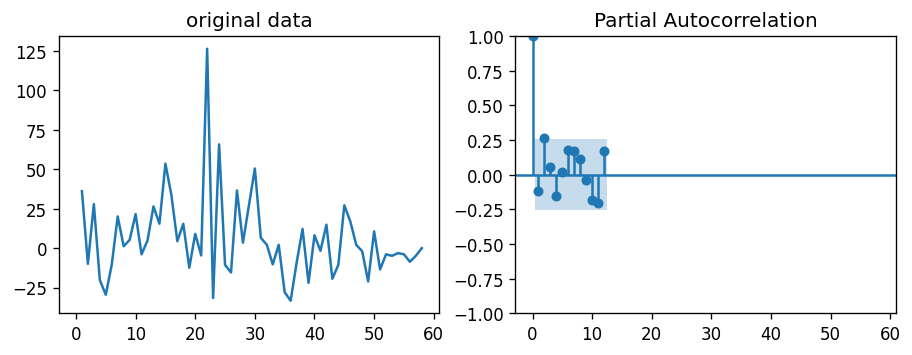

In [73]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(mdata['dhp']); axes[0].set_title('original data')
axes[1].set(ylim=(0,5))
plot_pacf(mdata['dhp'], lags=12,ax=axes[1])

plt.show()

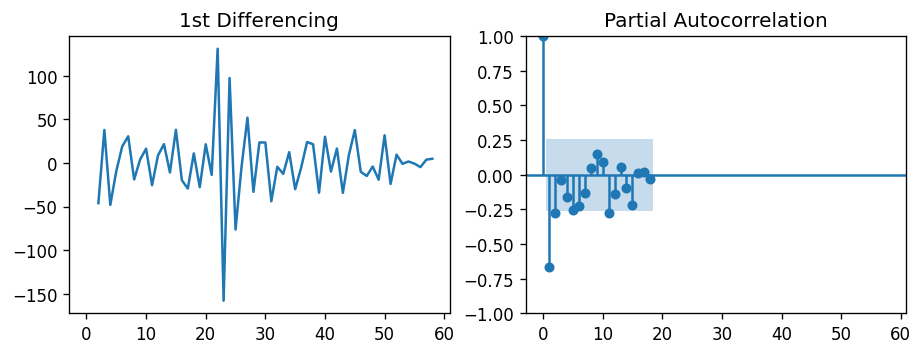

In [9]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(mdata['dhp'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(mdata['dhp'].diff().dropna(), ax=axes[1])

plt.show()


Here, we check the MA term, which is the error of the lagged forecast

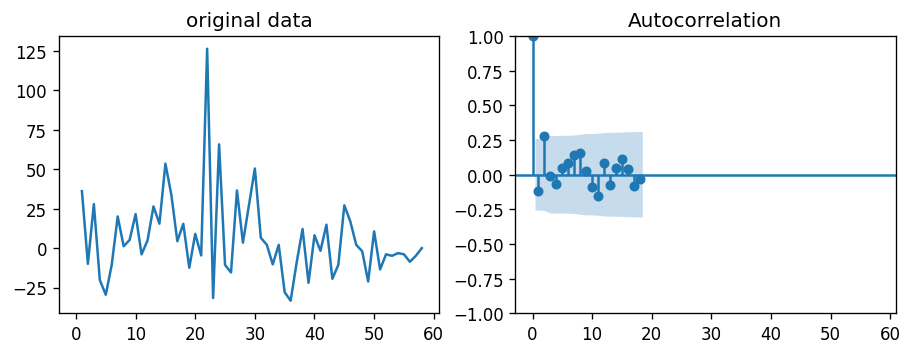

In [10]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(mdata['dhp']); axes[0].set_title('original data')
axes[1].set(ylim=(0,1.2))
plot_acf(mdata['dhp'].dropna(), ax=axes[1])

plt.show()

The following paragraph create the cutocorrelation function and partial autocorrelation function with time lags 12


In [11]:
acf, q, pval = smt.acf(mdata['dhp'], nlags = 12, qstat = True)
pacf = smt.pacf(mdata['dhp'], nlags=12)

correlogram = pd.DataFrame({'acf': acf[1:],
                           'pacf': pacf[1:],
                           'Q':q,
                           'p-val': pval})

correlogram

,acf,pacf,Q,p-val
0,-0.114009,-0.116009,0.793562,0.373025
1,0.276930,0.277092,5.559327,0.062059
2,-0.005590,0.055231,5.561304,0.135018
3,-0.067422,-0.162329,5.854247,0.210301
4,0.046993,0.018967,5.999248,0.306292
5,0.087970,0.197702,6.517148,0.367814
6,0.145623,0.199277,7.964144,0.335766
7,0.157507,0.135464,9.690809,0.287401
8,0.029064,-0.045186,9.750803,0.371033
9,-0.088918,-0.228395,10.324019,0.412541


the order argument specifies the order of the ARIMA model components in the following sequence: 
p(p, d, q)= 2
d(Differencing Order)=0
q (Moving Average Order)=2

*here, we change the dataset to monthly data, which only has 56 observations from Jan,2019 to Oct,2023, so the rule of thumb metrics is changed to +-1.96 x 1/(56)^(1/2)=+-0.26. We can see that even if we change the data to monthly one, still, no acf coefficients are insignificnat. 


In [12]:
print(len(mdata))

58


NOW, build the ARIMA model


In [13]:
res = smt.ARIMA(mdata['dhp'], order = (2, 0, 2)).fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    dhp   No. Observations:                   58
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -267.231
Date:                Wed, 18 Oct 2023   AIC                            546.463
Time:                        15:46:38   BIC                            558.825
Sample:                             0   HQIC                           551.278
                                 - 58                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2015      5.300      1.170      0.242      -4.186      16.589
ar.L1          0.6585      0.153      4.299      0.000       0.358       0.959
ar.L2         -0.6287      0.184     -3.414      0.0

/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARMA models is not based on any economic or financial theory, so it is often best not to even try to interpret the individual parameter estimates, but rather to examine the plausibility of the model as a whole, and to determine whether it describes the data well and produces accurate forecasts 

In [14]:
#  generate information criteria of the model
print(res.aic)
print(res.bic)

# the lower the AIC and BIC, more accurate the model is. 

546.4626800879917
558.8253381512702


In [15]:
# to check the prcess of the model is invertible and stationary
smt.ArmaProcess.from_estimation(res).isinvertible

True

In [16]:
smt.ArmaProcess.from_estimation(res).isstationary

True

The two other criteria of inverse and stationarity all satisfied, but to analyze the aic and bic and find out which has the smallest value, we perform the model slection process. 

In [17]:
res1 = smt.arma_order_select_ic(mdata['dhp'], 
                                max_ar = 4, max_ma=4, ic=['aic','bic'])
print('AIC')
print(res1.aic)
print('SBIC')
print(res1.bic)


/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/wangme

AIC
            0           1           2           3           4
0  547.331151  548.838914  544.680582  546.679859  548.488627
1  548.566875  549.165215  546.680138  548.669109  550.289010
2  546.239841  548.173265  546.462680  550.183606  548.189992
3  548.103941  549.706079  549.707734  548.240723  550.082079
4  548.913347  550.906654  548.129117  550.410289  552.022840
SBIC
            0           1           2           3           4
0  551.452037  555.020243  552.922354  556.982074  560.851285
1  554.748204  557.406987  556.982353  561.031767  564.712111
2  554.481613  558.475480  558.825338  564.606707  564.673536
3  558.406156  562.068737  564.130835  564.724267  568.626066
4  561.276005  565.329755  564.612661  568.954276  572.627270


/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


your time series data doesn't exhibit any significant autocorrelation or moving average behavior in the immediate past. This may be the case if your data appears to be a series of independent, randomly distributed values. It's a reasonable model when you believe there are no meaningful relationships between past values or past forecast errors in predicting the current value.

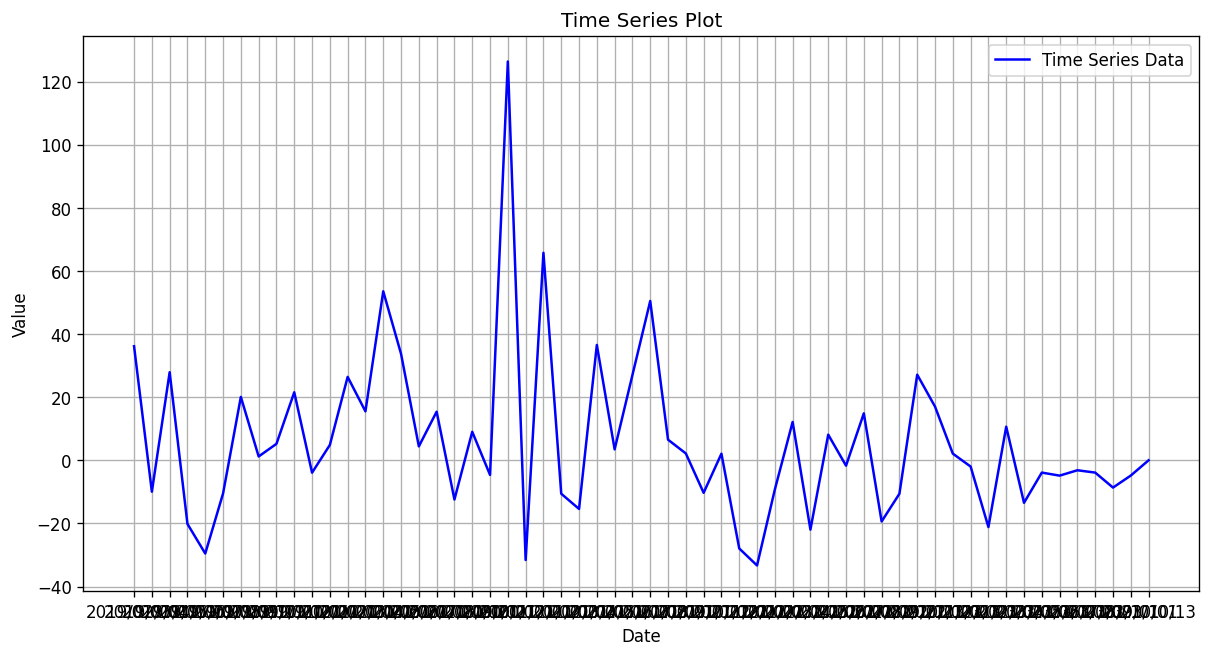

In [18]:
date = mdata['Date']
value = mdata['dhp']
plt.figure(figsize=(12, 6))
plt.plot(date, value, label='Time Series Data', color='blue')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

Forecasting using ARMA models

In [19]:
# forecast using ARMA models with order (0,0), 
# which is selected in the previous model selection process

In [20]:
mdata.head()

,Date,MRNA,dhp
1,2019/02/01,22.600000,36.144578
2,2019/03/01,20.350000,-9.955752
3,2019/04/01,26.030001,27.911553
4,2019/05/01,20.780001,-20.169035
5,2019/06/01,14.640000,-29.547645


we have 57 datapoints, and then we seperate data into 20% and 80%. The 20% is for testing the predicted data and another 80% is used for training the model

In [21]:
data_insample = mdata[:47]
data_insample.tail()


,Date,MRNA,dhp
43,2022/08/01,132.270004,-19.391793
44,2022/09/01,118.250000,-10.599534
45,2022/10/01,150.330002,27.128966
46,2022/11/01,175.910004,17.015899
47,2022/12/01,179.619995,2.109028


In [77]:
model = smt.ARIMA(data_insample['dhp'], order = (0, 0, 0))
res = model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    dhp   No. Observations:                   47
Model:                          ARIMA   Log Likelihood                -223.727
Date:                Thu, 19 Oct 2023   AIC                            451.455
Time:                        01:04:32   BIC                            455.155
Sample:                             0   HQIC                           452.847
                                 - 47                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3726      5.306      1.578      0.115      -2.026      18.772
sigma2       798.3531    116.874      6.831      0.000     569.284    1027.422
Ljung-Box (L1) (Q):                   1.13   Jarque-

/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


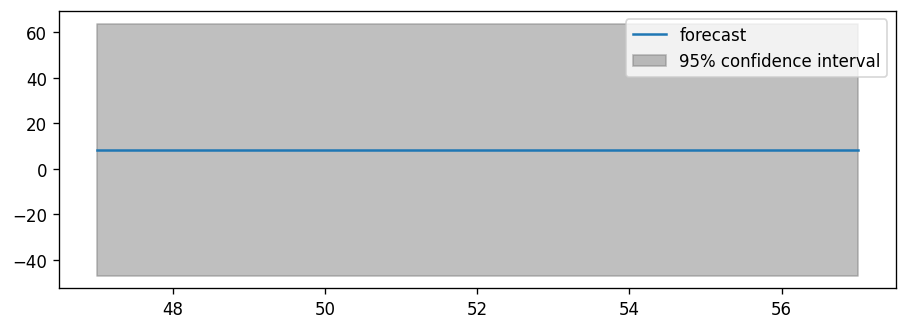

In [78]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots()
start_index = 47
end_index = 57
plot_predict(res, start=start_index,end=end_index, ax=ax)
plt.show()

因为做到这里的时候，作者崩溃了，所以决定move on 去下一part :)

In [24]:
data_insample.tail()

,Date,MRNA,dhp
43,2022/08/01,132.270004,-19.391793
44,2022/09/01,118.250000,-10.599534
45,2022/10/01,150.330002,27.128966
46,2022/11/01,175.910004,17.015899
47,2022/12/01,179.619995,2.109028


In [25]:
print(len(mdata))

58


In [26]:
data_outsample=mdata[48:]
data_outsample.tail()

,Date,MRNA,dhp
54,2023/07/01,117.660004,-3.160491
55,2023/08/01,113.070000,-3.901074
56,2023/09/01,103.290001,-8.649508
57,2023/10/01,98.300003,-4.831056
58,2023/10/13,98.300003,0.000000


In [27]:
import numpy as np
from math import sqrt

model = smt.ExponentialSmoothing(data_insample['dhp'])
res = model.fit()
start_index = 1
pred = res.predict(start=start_index)


/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


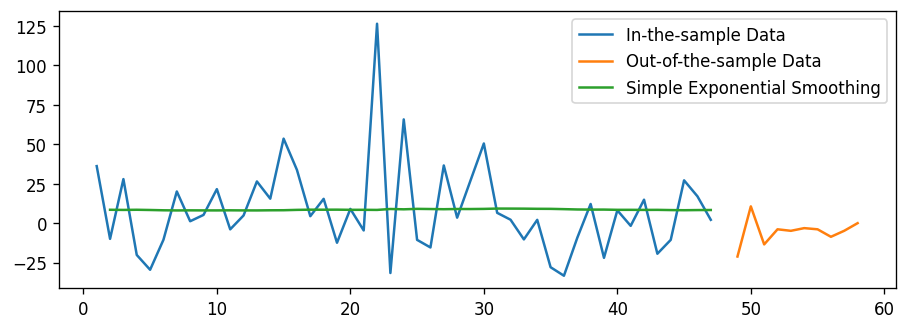

In [28]:
plt.figure(1)
plt.plot(data_insample['dhp'], label='In-the-sample Data')
plt.plot(data_outsample['dhp'], label='Out-of-the-sample Data')
plt.plot(pred, label='Simple Exponential Smoothing')
plt.legend()
plt.show()

In [29]:
def rmse(pred, target):
            return np.sqrt(((pred - target) ** 2).mean())
stats = rmse(pred,data_insample['dhp'])
print('Optimal smoothing coefficient: {}'.format(res.params['smoothing_level']))
print('root mean squared error: {}'.format(stats) )
print('sum-of-squared residuals: {}'.format(res.sse))

Optimal smoothing coefficient: 0.004935354929184913
root mean squared error: 28.331612928830058
sum-of-squared residuals: 37696.63343422741


In [30]:
ndata = pd.read_csv('/Users/wangmeiyi/Desktop/100dataset/5stocks.csv', index_col = 0)

In [31]:
ndata.head()

,ABBV,BIIB,CAH,FOLD,NBIX
Date,,,,,
2019-01-06,70.519859,318.329987,38.135895,10.89,74.709999
2019-01-13,69.918144,333.209991,40.402660,11.74,86.830002
2019-01-20,71.729416,337.420013,41.642159,12.31,91.529999
2019-01-27,64.548454,336.769989,41.896851,11.64,90.360001
2019-02-03,64.516380,330.910004,41.888367,12.08,88.190002


In [32]:
columns = ['ABBV','BIIB','CAH','FOLD','NBIX']
for column in columns:
    ndata[f'{column}_PC'] = ndata[f'{column}'].transform(lambda x: (x-x.shift(1))/x.shift(1)*100)
# this part is different from the log difference, becayse 
ndata = ndata.dropna()
ndata.head()

,ABBV,BIIB,CAH,FOLD,NBIX,ABBV_PC,BIIB_PC,CAH_PC,FOLD_PC,NBIX_PC
Date,,,,,,,,,,
2019-01-13,69.918144,333.209991,40.402660,11.74,86.830002,-0.853256,4.674396,5.943916,7.805320,16.222732
2019-01-20,71.729416,337.420013,41.642159,12.31,91.529999,2.590560,1.263474,3.067863,4.855202,5.412872
2019-01-27,64.548454,336.769989,41.896851,11.64,90.360001,-10.011181,-0.192645,0.611621,-5.442730,-1.278267
2019-02-03,64.516380,330.910004,41.888367,12.08,88.190002,-0.049690,-1.740056,-0.020249,3.780065,-2.401503
2019-02-10,63.851192,315.119995,44.715439,11.40,84.389999,-1.031037,-4.771693,6.749063,-5.629142,-4.308882


In [76]:
len(ndata)

243

In [33]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

columns = ['ABBV_PC','BIIB_PC','CAH_PC','FOLD_PC','NBIX_PC']
for column in columns:
    result = adfuller(ndata[f'{column}'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('\n')

ADF Statistic: -15.165752
p-value: 0.000000


ADF Statistic: -13.361529
p-value: 0.000000


ADF Statistic: -8.263086
p-value: 0.000000


ADF Statistic: -16.911071
p-value: 0.000000


ADF Statistic: -16.142148
p-value: 0.000000




In [34]:
acf, q, pval = smt.acf(ndata['dhp'], nlags = 12, qstat = True)
pacf = smt.pacf(ndata['dhp'], nlags=12)

correlogram = pd.DataFrame({'acf': acf[1:],
                           'pacf': pacf[1:],
                           'Q':q,
                           'p-val': pval})

correlogram

KeyError: 'dhp'

In [35]:

columns = ['ABBV_PC','BIIB_PC','CAH_PC','FOLD_PC','NBIX_PC']
for column in columns:
    res1 = smt.arma_order_select_ic(ndata[f'{column}'], 
    max_ar = 4, max_ma=4, ic=['aic','bic'])
    print('AIC')
    print(res1.aic_min_order)
    print('SBIC')
    print(res1.bic_min_order)
    print('\n')
    
# BIIB_PC has the bic minimum order of non-zero, so we use BIIB_PC

/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangme

AIC
(2, 4)
SBIC
(0, 0)




/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC
(2, 3)
SBIC
(0, 1)




/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC
(3, 3)
SBIC
(0, 0)




/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-p

AIC
(2, 2)
SBIC
(0, 0)




/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/wangmeiyi/anaconda3/lib/python3.10/site-p

AIC
(3, 3)
SBIC
(0, 0)




/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
res = smt.ARIMA(ndata['BIIB_PC'], order = (0, 0, 2)).fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                BIIB_PC   No. Observations:                  243
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -795.205
Date:                Wed, 18 Oct 2023   AIC                           1598.410
Time:                        15:47:13   BIC                           1612.382
Sample:                    01-13-2019   HQIC                          1604.038
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1267      0.368      0.344      0.731      -0.595       0.848
ma.L1         -0.2007      0.053     -3.759      0.000      -0.305      -0.096
ma.L2         -0.0819      0.078     -1.048      0.2

/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/wangmeiyi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [37]:
print(len(ndata))

243


In [38]:
print(ndata.head(),ndata.tail())

                 ABBV        BIIB        CAH   FOLD       NBIX    ABBV_PC  \
Date                                                                        
2019-01-13  69.918144  333.209991  40.402660  11.74  86.830002  -0.853256   
2019-01-20  71.729416  337.420013  41.642159  12.31  91.529999   2.590560   
2019-01-27  64.548454  336.769989  41.896851  11.64  90.360001 -10.011181   
2019-02-03  64.516380  330.910004  41.888367  12.08  88.190002  -0.049690   
2019-02-10  63.851192  315.119995  44.715439  11.40  84.389999  -1.031037   

             BIIB_PC    CAH_PC   FOLD_PC    NBIX_PC  
Date                                                 
2019-01-13  4.674396  5.943916  7.805320  16.222732  
2019-01-20  1.263474  3.067863  4.855202   5.412872  
2019-01-27 -0.192645  0.611621 -5.442730  -1.278267  
2019-02-03 -1.740056 -0.020249  3.780065  -2.401503  
2019-02-10 -4.771693  6.749063 -5.629142  -4.308882                     ABBV        BIIB        CAH   FOLD        NBIX   ABBV_PC  \
Date

In [39]:
# the ndata dataframe has 243 rows, so 242 data points
from statsmodels.graphics.tsaplots import plot_predict



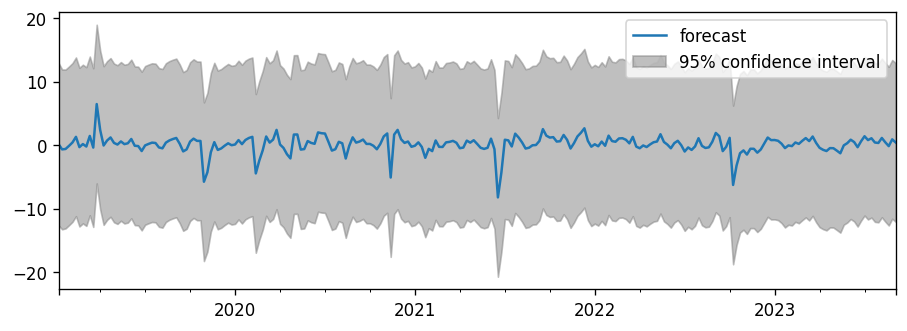

In [63]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()

# Plot the predicted data
plot_predict(res, '2019/01/13', '2023/09/03', ax=ax, label='Predicted Data')
plt.show()


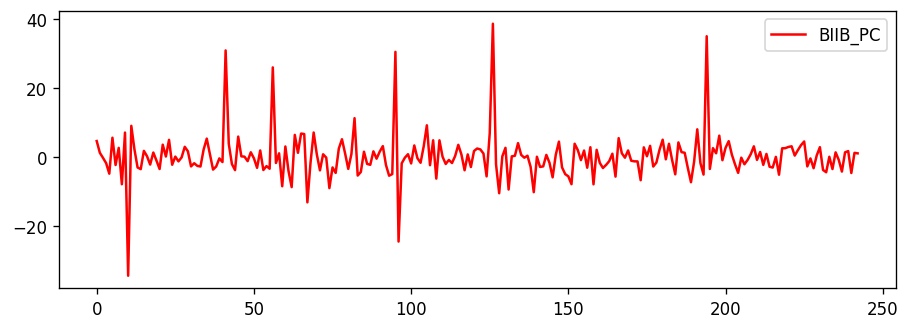

In [64]:
biib_pc = ndata['BIIB_PC']

# Plot the 'BIIB_PC' data
plt.plot(biib_pc, label='BIIB_PC', color='red')  # You can adjust color and label as needed

# Add a legend
plt.legend()

In [65]:
import pandas as pd
import numpy as np

# Define the start and end dates for the weekly date range
start_date = '2019-01-13'
end_date = '2023-09-03'

# Generate a weekly date range
date_range = pd.date_range(start=start_date, end=end_date, freq='W')

# Create a sample DataFrame with the 'BIIC_PC' column
# Replace this with your actual DataFrame
data = {'BIIC_PC': np.random.rand(len(date_range))}
df = pd.DataFrame(data, index=date_range)

# Display the DataFrame with the updated index
print(df)


             BIIC_PC
2019-01-13  0.444870
2019-01-20  0.082188
2019-01-27  0.316221
2019-02-03  0.335435
2019-02-10  0.410958
...              ...
2023-08-06  0.724347
2023-08-13  0.023020
2023-08-20  0.623239
2023-08-27  0.281044
2023-09-03  0.626048

[243 rows x 1 columns]


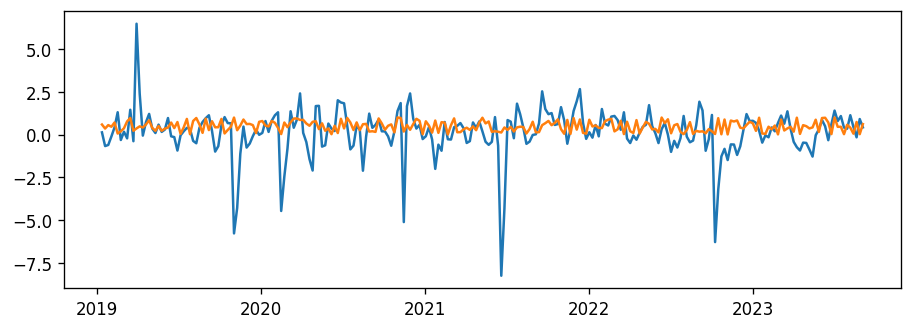

In [61]:
import statsmodels.tools.eval_measures as em

plt.plot(res.predict())
plt.plot(df)